In [1]:
import numpy as np
import numpy.linalg as la
from itertools import combinations
from scipy.linalg import toeplitz
from collections import Counter
from matplotlib.pyplot import plot
import matplotlib.pyplot as plt
import kblock_ising_model as kb

In [33]:
L = 100
k_vals = kb.k_vals(L)
g = np.linspace(0,2,100)

In [50]:
#Basic Projector stuff

#Ground states

U_gs = []
for gi in g:
    U_gs.append(kb.U(k_vals,gi))

#Projectors
max_n = 8


P = np.empty([max_n,len(g)])

for i in range(len(g)):
    U = U_gs[i]
    for n in range(1,max_n+1):
        P[n-1,i] = kb.P_n(n,U,k_vals,False)


/tmp/ipykernel_10126/3765981658.py:18: ComplexWarning: Casting complex values to real discards the imaginary part
  P[n-1,i] = kb.P_n(n,U,k_vals,False)


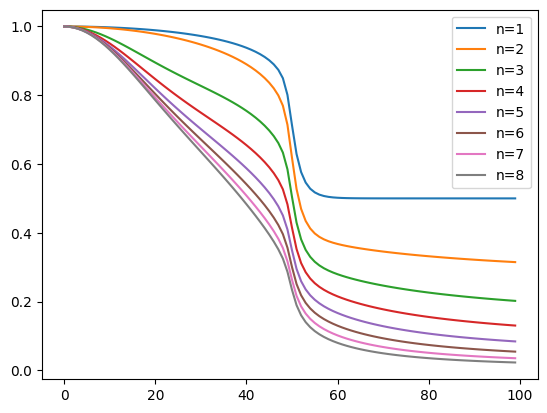

In [51]:
plot(P.T,label=[f"n={i+1}" for i in range(P.shape[0])])
plt.legend()


In [36]:
#Compare to other method

import sys
import os
from time import time
sys.path.append("../../../../src/")
#Imports
import single_particle_sector as sps
import numpy as np
import scipy as sp
import numpy.linalg as la
import matplotlib.pyplot as plt
from matplotlib.pyplot import plot, scatter

In [37]:
J = 1
P2 = np.empty([max_n,len(g)])
for i in range(len(g)):
        H = sps.H_bdg(g[i],L,J,"ABC")
        E,V = la.eigh(H)
        #The only sublety is this step
        #G_TFIM chooses ((1 0),(0 0 )) corr
        G = sps.G_tfim(V[:,L:])
        for n in range(1,max_n+1):
                P2[n-1,i] = sps.P_n(n,G,L)        


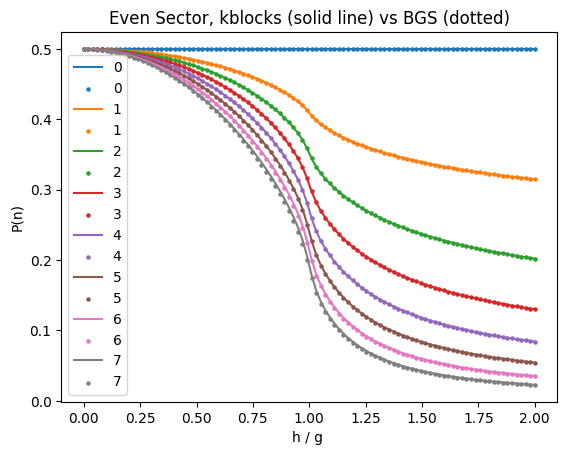

In [49]:
for i in range(P2.shape[0]):
    plt.plot(g, P[i], label=f"{i}")
    plt.scatter(g, P2[i], label=f"{i}", marker='o',s=5)
plt.title("Even Sector, kblocks (solid line) vs BGS (dotted)")
plt.legend()
plt.xlabel("h / g ")

plt.ylabel("P(n)")

plt.savefig("P_n_vs_h_even_sector_kblocks_vs_BGS.png")